In [1]:
from vlmx.agent import Agent, AgentConfig
from dotenv import load_dotenv
from vlmx.context_agent import ContextAwareAgent
import os
import tempfile
from vlmx.tool_use_agent import ToolUseAgent, TOOL_INSTRUCTION
from vlmx.artifact import ArtifactDisplayHandler, artifacts_to_prompt_parts, ArtifactCollector
from typing import Dict, Any, Optional, List, Union
import sys
from io import StringIO
from vlmx.utils import string_to_file, join_path, extract_code_from_string
from contextlib import contextmanager
from io import StringIO
from PIL import Image
from pathlib import Path

/home/vlongle/miniconda3/envs/vlmx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## we have our API key stored in a .env file
load_dotenv()
API_KEY = os.environ.get('API_KEY')

## Basic

In [3]:
SYSTEM_INSTRUCTION = "Do whatever I say correctly."

class HelperAgent(Agent):
    OUT_RESULT_PATH = "test.txt"

    def _make_system_instruction(self):
        return SYSTEM_INSTRUCTION

    def _make_prompt_parts(self, question: str):
        return question

    def parse_response(self, response):
        print("response:", response.text)
        ## string_to_file(response.txt, "path.txt")

In [4]:
cfg = AgentConfig(model_name="gemini-2.0-flash-thinking-exp-01-21",
                out_dir=f"test_results",
                api_key=API_KEY)
agent = HelperAgent(cfg)
agent.generate_prediction("What's 2+2?");

response: 4


## Cursor-style File Context

You can use the `@` symbol to reference files in the current directory, and we will automatically include the file in the prompt, and manage duplicated files ect.

In [5]:
class FileContextAgent(ContextAwareAgent):
    OUT_RESULT_PATH = "out.txt"
    
    def _make_system_instruction(self) -> str:
        return f"""Answer the question correctly."""

    def parse_response(self, response, **kwargs):
        print("response:", response.text)

In [6]:
def create_temp_file(content):
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        temp_file.write(content.encode('utf-8'))
        return temp_file.name

In [7]:
a_content = "x=10"
b_content = "x=9**2"

a_file = create_temp_file(a_content)
b_file = create_temp_file(b_content)

print("a_file:", a_file)
print("b_file:", b_file)

a_file: /tmp/tmpkoqb_rj3
b_file: /tmp/tmpbgthoy9r


In [8]:
file_agent = FileContextAgent(AgentConfig(model_name="gemini-2.0-flash-thinking-exp-01-21",
            out_dir=f"test_intelligent_results",
            api_key=API_KEY))

prompt_parts = [
    f"What's the difference between @{a_file} and @{b_file} ?",
]
file_agent.generate_prediction(
    prompt_parts,
    overwrite=True,
);

response: The difference between [tmpkoqb_rj3] and [tmpbgthoy9r] is in the value assigned to the variable `x`.

* **[tmpkoqb_rj3]** assigns the value `10` to the variable `x`.
* **[tmpbgthoy9r]** assigns the value `81` (which is the result of `9**2`, or 9 squared) to the variable `x`.

In essence, both files define a variable `x`, but they initialize it with different numerical values.  The first file uses a literal value, while the second file uses an exponentiation operation to calculate the value.


## Tool Usage and artifacts

We only equip the VLM with ability to `save_logs` and `save_images` to a workspace. This allows the VLM to save intermediate results and later retrieve them results for iterative refinement. Here's a basic example.

In [9]:
class ToolAgent(ToolUseAgent):
    OUT_RESULT_PATH = "tool_use_result.txt"
    PYTHON_FILE_NAME = "tool_use_agent.py"
    
    def __init__(self, config, working_dir: str = "./vlm_workspace"):
        super().__init__(config, working_dir)
        self.artifact_handler = ArtifactDisplayHandler()
        self.additional_context = None
        self.previous_code = None  # Track previous code for diff generation

    def _make_system_instruction(self) -> str:
        return super().add_file_context("You're an helpful assistant."+ TOOL_INSTRUCTION) 

    def add_context(self, context: Dict[str, Any]):
        """Add context from previous iterations to help improve the solution"""
        self.additional_context = context
        # Extract previous code from context if available
        if context and 'code' in context:
            self.previous_code = context['code']

    def _make_prompt_parts(self, task: str) -> List[Union[str, Image.Image]]:
        """Generate prompt parts including both text and images/videos"""
        prompt_parts = [f"task: {task}"]

        
        # Add context from previous iterations if available
        if self.additional_context:
            prompt_parts.append("\nPrevious attempt results:")
            prompt_parts.extend(artifacts_to_prompt_parts(self.additional_context))
            prompt_parts.append("\nPlease analyze the previous attempt and improve the solution. ")
        
        return super()._make_prompt_parts(prompt_parts)


    @staticmethod
    @contextmanager
    def capture_output():
        """Capture stdout while still allowing it to print to console"""
        stdout = StringIO()
        original_stdout = sys.stdout
        class TeePrint:
            def write(self, data):
                stdout.write(data)
                original_stdout.write(data)
            def flush(self):
                stdout.flush()
                original_stdout.flush()
        
        sys.stdout = TeePrint()
        try:
            yield stdout
        finally:
            sys.stdout = original_stdout

    def parse_response(self, response, **kwargs):
        """Parse response and handle both full code and diffs"""
        code = extract_code_from_string(response.text)

        # Save the full response and extracted code
        string_to_file(response.text, join_path(self.cfg.out_dir, self.OUT_RESULT_PATH))
        string_to_file(code, join_path(self.cfg.out_dir, self.PYTHON_FILE_NAME))
        
        # Capture both stdout and execution results
        with self.capture_output() as output:
            success, error = self.execute_code(code)
        
        # Save stdout to output.txt
        stdout_content = output.getvalue()
        if stdout_content:
            string_to_file(stdout_content, join_path(self.cfg.out_dir, "stdout.txt"))
        
        if not error:
            print("\nCode executed successfully!")
            # Display all artifacts in the working directory
            # self.artifact_handler.display_artifacts(Path(self.working_dir))
        else:
            print(f"Error executing code: {error}")
            # Save the error to stderr.txt
            string_to_file(error, join_path(self.cfg.out_dir, "stderr.txt"))


In [10]:
agent = ToolAgent(AgentConfig(
    model_name="gemini-2.0-flash-thinking-exp-01-21",
    out_dir="test_tool_use_results",
    api_key=API_KEY
))

# Test simple math problem
question = """Calculate the square of numbers from 1 to 5. 
Plot the results and save both the data and plot."""

agent.generate_prediction(question);


Code executed successfully!


In [11]:
agent.working_dir

PosixPath('test_tool_use_results/vlm_workspace')

In [12]:
!ls test_tool_use/vlm_workspace/images

ls: cannot access 'test_tool_use/vlm_workspace/images': No such file or directory


In [13]:
context = ArtifactCollector(Path(agent.cfg.out_dir)).collect()
## agent.add_context(context) ## for iterative refinement.
context

{'code': 'import matplotlib.pyplot as plt\n\n# Calculate squares\nnumbers = list(range(1, 6))\nsquares = [n**2 for n in numbers]\n\n# Create plot\nplt.plot(numbers, squares)\nplt.xlabel("Numbers")\nplt.ylabel("Squares")\nplt.title("Squares of Numbers from 1 to 5")\nplt.grid(True)\n\n# Save plot\nsave_image("squares_plot", plt.gcf())\n\n# Save data\ndata = {"numbers": numbers, "squares": squares}\nlog_data("squares_data", data)',
 'stdout': None,
 'stderr': None,
 'images': [{'name': 'squares_plot_20250224_191625.png',
   'data': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480>}],
 'videos': [],
 'logs': [{'name': 'squares_data_20250224_191625.json',
   'data': {'numbers': [1, 2, 3, 4, 5], 'squares': [1, 4, 9, 16, 25]}}]}


=== Code ===

📁 tool_use_agent.py
import matplotlib.pyplot as plt

# Calculate squares
numbers = list(range(1, 6))
squares = [n**2 for n in numbers]

# Create plot
plt.plot(numbers, squares)
plt.xlabel("Numbers")
plt.ylabel("Squares")
plt.title("Squares of Numbers from 1 to 5")
plt.grid(True)

# Save plot
save_image("squares_plot", plt.gcf())

# Save data
data = {"numbers": numbers, "squares": squares}
log_data("squares_data", data)


=== Standard Output ===

📁 stdout.txt

=== Standard Error ===

📁 stderr.txt

=== Images ===

=== Artifacts in images ===

📁 squares_plot_20250224_191625.png


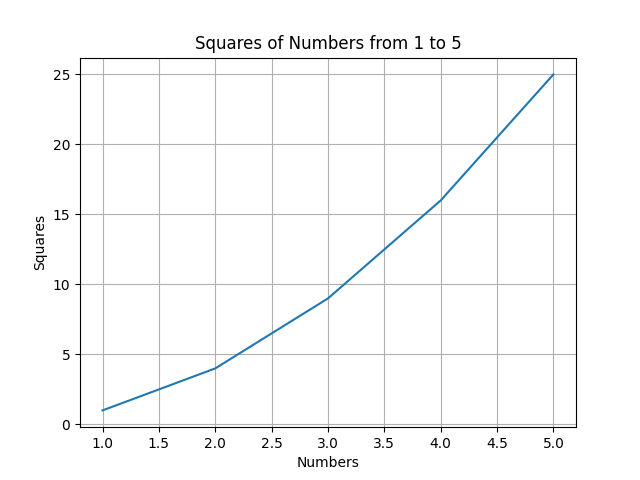


=== Videos ===
No artifacts found in test_tool_use_results/vlm_workspace/videos

=== Logs ===

=== Artifacts in logs ===

📁 squares_data_20250224_191625.json
{
  "numbers": [
    1,
    2,
    3,
    4,
    5
  ],
  "squares": [
    1,
    4,
    9,
    16,
    25
  ]
}


In [14]:
ArtifactDisplayHandler(Path(agent.cfg.out_dir)).display_all()